In [4]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost
from sklearn.metrics import mean_pinball_loss
import time
# Generate a synthetic dataset for regression
X, y = make_regression(n_samples=1000, n_features=1, noise=7, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize an XGBRegressor with the "reg:quantileerror" objective and specify the target quantile
quantile = 0.5
params = {'grow_policy': 'depthwise', 'booster': 'gbtree', 'predictor': 'auto', 'verbosity': 0, 'n_jobs': -1, 'tree_method': 'hist', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'min_child_weight': 10, 'learning_rate': 0.10670869913007261, 'subsample': 0.8, 'colsample_bytree': 0.9000000000000001, 'n_estimators': 80, 'reg_lambda': 0.65, 'reg_alpha': 0.8500000000000001, 'max_depth': 1, 'random_state': 79858}
"""
s = time.time()
sa1 = xgboost.QuantileDMatrix(X_train, y_train)
model = xgboost.train(params=params, dtrain=sa1, num_boost_round=params['n_estimators'])
print(time.time()-s)
"""

s = time.time()
model = XGBRegressor(**params)
model.fit(X_train, y_train)
print(time.time()-s)
# Fit the model on the training data
test = xgboost.QuantileDMatrix(X_test)

# Make predictions on the test set
y_pred = model.predict(test)

# Calculate the quantile loss (pinball loss) of the predictions
quantile_loss = mean_pinball_loss(y_test, y_pred, alpha=quantile)
print(f"Quantile Loss (Pinball Loss) at {quantile} quantile: {quantile_loss:.4f}")

26.836954355239868


/home/a2a/a2a/bin/lib/python3.12/site-packages/xgboost/data.py:1320: UserWarning: Unknown data type: <class 'xgboost.core.QuantileDMatrix'>, trying to convert it to csr_matrix
  warnings.warn(


TypeError: Not supported type for data.<class 'xgboost.core.QuantileDMatrix'>

In [71]:
x_sorted.shape

(200,)

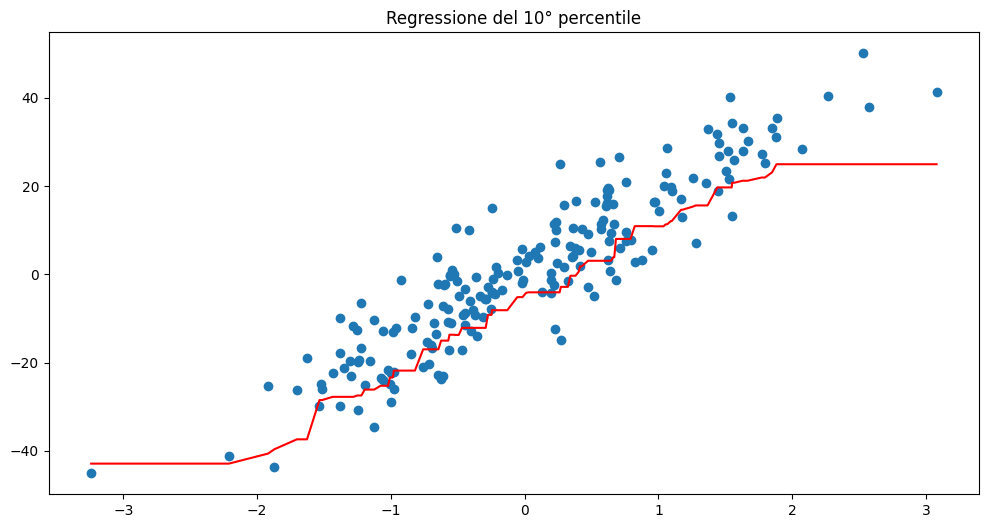

In [92]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(12, 6))
plt.scatter(X_test, y_test)
x_sorted = np.sort(X_test, axis=0)
x_s = xgboost.QuantileDMatrix(x_sorted)

y_pred = model.predict(x_s)

plt.plot(x_sorted, y_pred, color='red')
plt.title('Regressione del 10° percentile')
plt.show()

In [67]:
import pandas as pd
from datetime import date


df1 = pd.read_parquet('/home/a2a/a2a/RL_Trading/prj/app/core/data/dataset_old.parquet')
df2 = pd.read_parquet('/home/a2a/a2a/RL_Trading/prj/app/core/data/dataset_full.parquet')
print(df2.columns)

date_ranges = [[date(2023,1,1), date(2023,7,1)]]
mask = np.logical_or.reduce([
            df2['time'].dt.date.between(start, end)  # inclusive on both ends
            for start, end in date_ranges
        ])

df1 = df1[df1.columns.intersection(df2.columns)]
df1 = df1.groupby(['time']).first().reset_index()
df2 = df2[mask]
df2 = df2[df1.columns.intersection(df2.columns)]

Index(['next_pct_spread', 'delta_mid_3', 'pct_delta', 'mid_rsi_8400',
       'next_pct_delta_ewm_18000', 'pct_spread', 'next_delta_mid_0',
       'pct_spread_ewm_18000', 'mid_std', 'next_delta_mid_1',
       'traded_quantity_rolling_mean', 'next_delta_mid_2',
       'pct_delta_std_18000', 'next_max_diff_ask', 'ratio_mid_week',
       'max_diff_ask_level', 'next_mid_rsi_8400', 'pct_spread_std_18000',
       'rolling_std', 'rolling_mean', 'delta_mid_0', 'mid_macd_7200_15600',
       'next_mid_macd_7200_15600', 'next_pct_spread_std_18000',
       'next_time_to_roll', 'day_of_week', 'ratio_spread_date', 'delta_mid_4',
       'next_month', 'spread', 'time', 'max_diff_ask', 'ratio_mid_month',
       'next_mid', 'next_pct_delta_std_18000', 'pct_delta_ewm_18000',
       'next_minute_of_day', 'time_to_roll', 'next_ratio_mid_month', 'ask_0',
       'next_ratio_spread_month', 'month', 'next_spread_std',
       'next_delta_mid_3', 'spread_std', 'next_spread', 'next_ratio_mid_date',
       'next_de

In [66]:
columns = df1.columns.intersection(df2.columns)
column = columns[9]
print(column)
mask = df1[column].to_numpy() != df2[column].to_numpy()
df1.loc[mask][[column]+['time']]
#mid_rsi, macd
#delta

delta_mid_2


,delta_mid_2,time
0,NaN,2023-01-02 08:00:00
1,NaN,2023-01-02 08:01:00
2,NaN,2023-01-02 08:02:00
3,NaN,2023-01-02 08:03:00
4,NaN,2023-01-02 08:04:00
...,...,...
264,NaN,2023-01-02 12:24:00
265,NaN,2023-01-02 12:25:00
266,NaN,2023-01-02 12:26:00
267,NaN,2023-01-02 12:27:00


In [2]:
from core.fqi.simulator.dataset_builder import DatasetBuilder
from core.fqi.simulator.simulator import TTFEnv
import numpy as np
from pathlib import Path

import pandas as pd

data_root = '/home/a2a/a2a/RL_Trading/prj/app/core/data'
config_path = '/home/a2a/a2a/RL_Trading/prj/app/config/config.yaml'
persistence = 20 #min
data_builder = DatasetBuilder(data_root, config_path, persistence)
#data_path = Path('C:/Users/Riccardo/Documents/df_simulator.parquet')

env = TTFEnv(data_path=data_builder)#

n_eval_days = 10
rewards = []
for day in range(n_eval_days):
    print(f'Starting day {day}')
    done = False
    day_reward = 0
    ep_len = 0
    while not done:
        # action, _ = model.predict(obs, deterministic=True)
        action = np.random.choice(3, size=1)

        obs, reward, terminated, info = env.step(action)
        done = terminated
        day_reward += reward
        ep_len+=1

    rewards.append(day_reward)

print(f"Simulation complete. Mean episode reward={np.mean(rewards):.3f}, Return={np.sum(rewards):.3f}%, Episode length: {ep_len}")


/home/a2a/a2a/RL_Trading/prj/app/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


AttributeError: 'DatasetBuilder' object has no attribute 'startswith'

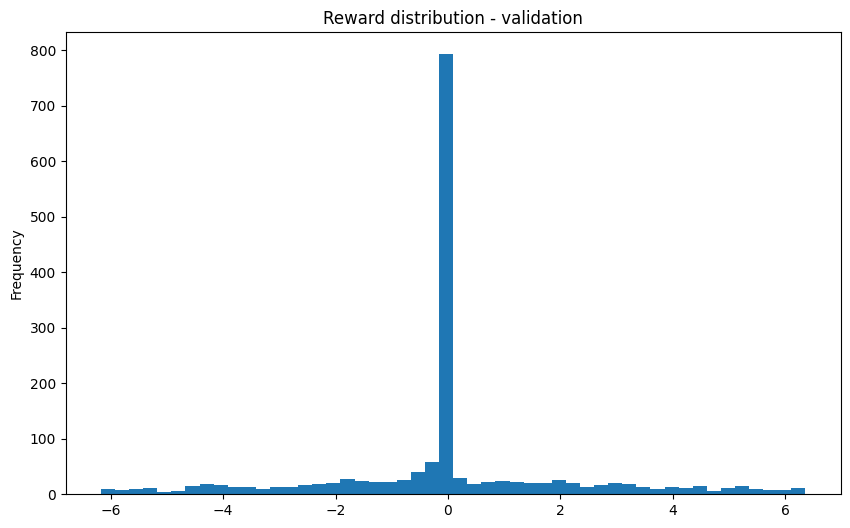

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

df = pd.read_csv('/home/a2a/a2a/RL_Trading/results/experts_overnight/1y23_7y23/seed98032/Results_iter3_Validation.csv')

ax = df[(df.reward < df.reward.quantile(0.95)) & (df.reward > df.reward.quantile(0.05))]['reward'] \
        .plot.hist(bins=50, figsize=(10, 6))

ax.set_title("Reward distribution - validation")
plt.show()

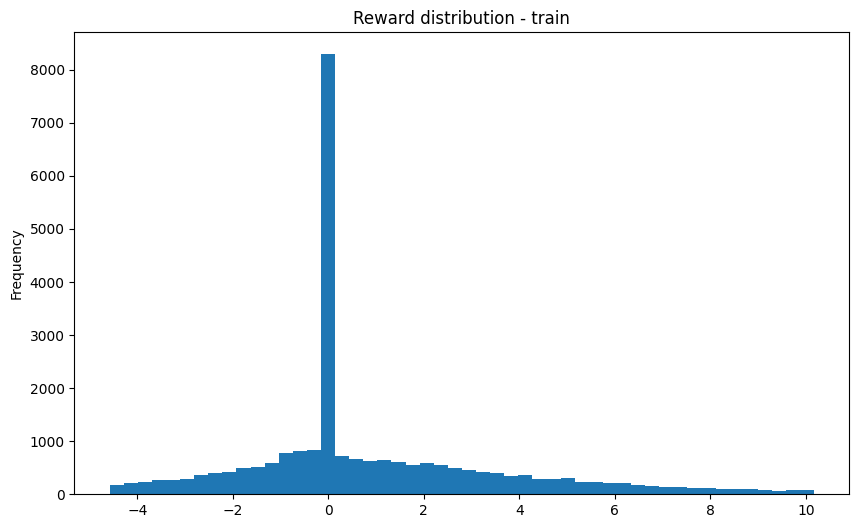

In [4]:
df = pd.read_csv('/home/a2a/a2a/RL_Trading/results/experts_overnight/1y23_7y23/seed98032/Results_iter3_Train.csv')


ax = df[(df.reward < df.reward.quantile(0.95)) & (df.reward > df.reward.quantile(0.05))]['reward'] \
        .plot.hist(bins=50, figsize=(10, 6))

ax.set_title("Reward distribution - train")
plt.show()

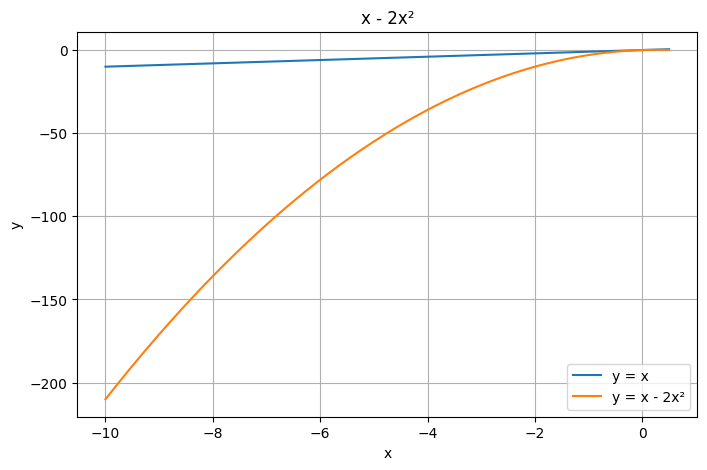

In [12]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-10, 0.5, 400)
y1 = x
y2 = x - 1 * 2*x**2

plt.figure(figsize=(8, 5))
plt.plot(x, y1, label="y = x")
plt.plot(x, y2, label="y = x - 2x²")
plt.xlabel("x")
plt.ylabel("y")
plt.title("x - 2x²")
plt.legend()
plt.grid(True)
plt.show()